In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os, sys
os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

In [4]:
pip install GPy

In [5]:
# importing needed libraries
import matplotlib.pyplot as plt
import numpy as np
import os, sys
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
from dmref import MFGP
import matplotlib.mlab as ml
import warnings
warnings.filterwarnings("ignore")
np.random.seed(11)

In [7]:
#Load the high-fidelity data
import re
os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')
os.chdir('high_fidelity_simulations')

filenames= os.listdir (".") # get all files' and folders' names in the current directory
folder_names = []
for filename in filenames: # loop through all the files and folders
    if os.path.isdir(os.path.join(os.path.abspath("."), filename)): # check whether the current object is a folder or not
        folder_names.append(filename)
        
Xh = np.empty((0, 2))
Yh = np.empty((0, 1))
for i in range(0, len(folder_names)):
  os.chdir(folder_names[i])

  name = [float(s) for s in re.findall(r'-?\d+\.?\d*',folder_names[i])]
  omega = name[0]
  Ca = name[1]
  if Ca==0.25:
    pass
  else:
    Xh = np.append(Xh, np.array([[omega, Ca]]), axis=0)

    mean = np.loadtxt('mean.dat')
    if omega!=0:
      first_value = int(mean[-1,0]-2*np.pi/omega)            
      finding_vector = mean[:,0].astype(int)
      first_index = np.where((finding_vector)==first_value)
      focusing_distance = np.mean(mean[first_index[-1][-1]:-1,1])
      Yh = np.append(Yh, np.array([[focusing_distance]]), axis=0)
    else:
      focusing_distance = mean[-1, 1]
      Yh = np.append(Yh, np.array([[focusing_distance]]), axis=0)
  
  os.chdir('..')

print 'Number of high-fidelity points:', Yh.shape[0]

Number of high-fidelity points: 22


In [8]:
#Load the low-fidelity data
import re
os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')
os.chdir('low_fidelity_simulations')

filenames= os.listdir (".") # get all files' and folders' names in the current directory
folder_names = []
for filename in filenames: # loop through all the files and folders
    if os.path.isdir(os.path.join(os.path.abspath("."), filename)): # check whether the current object is a folder or not
        folder_names.append(filename)

Xl = np.empty((0, 2))
Yl = np.empty((0, 1))
for i in range(0, len(folder_names)):
  os.chdir(folder_names[i])

  name = [float(s) for s in re.findall(r'-?\d+\.?\d*',folder_names[i])]
  omega = name[0]
  Ca = name[1]
  if Ca==0.25:
    pass
  else:
    Xl = np.append(Xl, np.array([[omega, Ca]]), axis=0)

    mean = np.loadtxt('mean.dat')
    if omega!=0:
      first_value = int(mean[-1,0]-2*np.pi/omega)            
      finding_vector = mean[:,0].astype(int)
      first_index = np.where((finding_vector)==first_value)
      focusing_distance = np.mean(mean[first_index[-1][-1]:-1,1])
      Yl = np.append(Yl, np.array([[focusing_distance]]), axis=0)
    else:
      focusing_distance = mean[-1, 1]
      Yl = np.append(Yl, np.array([[focusing_distance]]), axis=0)
  
  os.chdir('..')

print 'Number of low-fidelity points:', Yl.shape[0]

Number of low-fidelity points: 29


In [9]:
#Perform the MFGP on a continuous range of inputs
import GPy
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

import time

np.random.seed(11)

def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))


''' Create training set '''
plot = 1
save = 0

dim = 2        #number of fidelity levels
nx1 = 100      #number of grids along the first dimension
nx2 = 100      #number of grids along the second dimension
x1 = np.linspace(0, 1, nx1)             #range of frequency for test
x2 = np.linspace(0.09, 1.67, nx2)       #range of capillary number for test
x1, x2 = np.meshgrid(x1, x2)

Xtest = np.hstack([x1.flatten()[:, None], x2.flatten()[:, None]])
ntest = Xtest.shape[0]

active_dimensions = np.arange(0,dim)

start = time.time()

''' Train level 1 '''
k1 = GPy.kern.RBF(dim, ARD = True)
m1 = GPy.models.GPRegression(X=Xl, Y=Yl, kernel=k1)

m1[".*Gaussian_noise"] = m1.Y.var()*0.01
m1[".*Gaussian_noise"].fix()

m1.optimize(max_iters = 500)

m1[".*Gaussian_noise"].unfix()
m1[".*Gaussian_noise"].constrain_positive()

m1.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000, verbose = 0)

mu1, v1 = m1.predict(Xh)


''' Train level 2 '''
XX = np.hstack((Xh, mu1))

k2 = GPy.kern.RBF(1, active_dims = [dim])*GPy.kern.RBF(dim, active_dims = active_dimensions, ARD = True) \
    + GPy.kern.RBF(dim, active_dims = active_dimensions, ARD = True)

m2 = GPy.models.GPRegression(X=XX, Y=Yh, kernel=k2)

m2[".*Gaussian_noise"] = m2.Y.var()*0.01
m2[".*Gaussian_noise"].fix()

m2.optimize(max_iters = 500)

m2[".*Gaussian_noise"].unfix()
m2[".*Gaussian_noise"].constrain_positive()

m2.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000, verbose = 0)

''' Predict at test points '''
# sample f_1 at xtest
nsamples = 1000
mu1, C1 = m1.predict(Xtest, full_cov=True)
Z = np.random.multivariate_normal(mu1.flatten(),C1,nsamples)

# push samples through f_2
tmp_m = np.zeros((nsamples,ntest))
tmp_v = np.zeros((nsamples,ntest))
for i in range(0,nsamples):
    mu, v = m2.predict(np.hstack((Xtest, Z[i,:][:,None])))
    tmp_m[i,:] = mu.flatten()
    tmp_v[i,:] = v.flatten()

# get posterior mean and variance
mean = np.mean(tmp_m, axis = 0)[:,None]
var = np.mean(tmp_v, axis = 0)[:,None]+ np.var(tmp_m, axis = 0)[:,None]
var = np.abs(var)

No handlers could be found for logger "variance"


The following cell confirms that for steady flows, the lowest Capillary has the highest equilibrium distance from center and vice versa.

In [17]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

new_vector = np.zeros((nx2, 1))
for i in range(0, nx2):
  new_vector[i] = mean[i*nx1]      #stores the high-fidelity prediction of equilibrium distance for steady flows (frequency=0) at different capillary numbers.

print 'Where max distance occurs:', np.where(new_vector == np.max(new_vector))
print 'Where min distance occurs:', np.where(new_vector == np.min(new_vector))

Where max distance occurs: (array([0]), array([0]))
Where min distance occurs: (array([99]), array([0]))


In [21]:
#Installing LaTex packages
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
--2021-02-27 17:36:07--  http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
Resolving mirrors.ctan.org (mirrors.ctan.org)... 5.35.249.60
Connecting to mirrors.ctan.org (mirrors.ctan.org)|5.35.249.60|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ctan.math.illinois.edu/macros/latex/contrib/type1cm.zip [following]
--2021-02-27 17:36:07--  https://ctan.math.illinois.edu

In [22]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


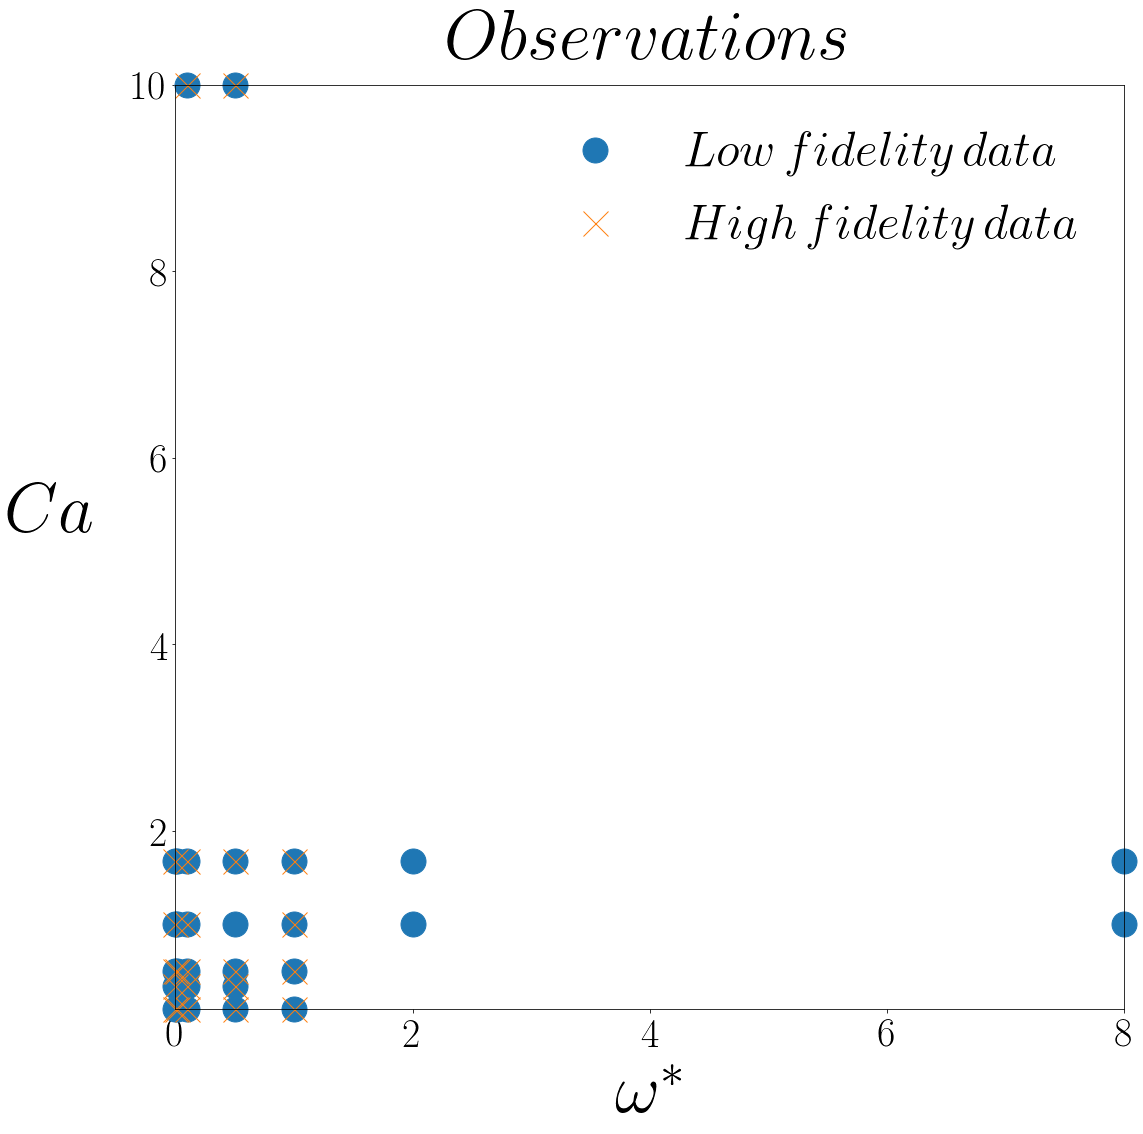

In [24]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

if plot == 1:
    Highplot = ml.griddata(Xtest[:,0],Xtest[:,1], mean.flatten(), x1, x2, interp = 'linear')
    Lowplot = ml.griddata(Xtest[:,0],Xtest[:,1], mu1.flatten(), x1, x2, interp = 'linear')
    Varplot = ml.griddata(Xtest[:,0],Xtest[:,1], var.flatten(), x1, x2, interp = 'linear')

    fig , ax = plt.subplots(1,1,figsize = (17,17))
    ax.plot(Xl[:,0], Xl[:,1], marker='o', markersize = 25, linestyle = '', clip_on = False, label=r'$Low \, fidelity \, data$')
    ax.plot(Xh[:,0], Xh[:,1], marker='x', markersize = 25, linestyle = '', clip_on = False, label=r'$High \, fidelity \, data$')
    plt.title(r'$Observations$',fontsize=70, y=1.02)
    ax.set_xlabel(r'$\omega^*$', fontsize=70)
    ax.set_ylabel(r'$Ca$', fontsize=70, rotation = 0)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    plt.xlim(0, 8)
    plt.ylim(0.09, 10)
    ax.legend(frameon=False,fontsize=50, ncol=1, loc='upper right')
    plt.savefig('observations.png', bbox_inches = 'tight', pad_inches = 0)

In the following figure, red surface plot denotes the high-fidelity prediction of equilibrium distance, and green plot shows the low-fidelity prediction.

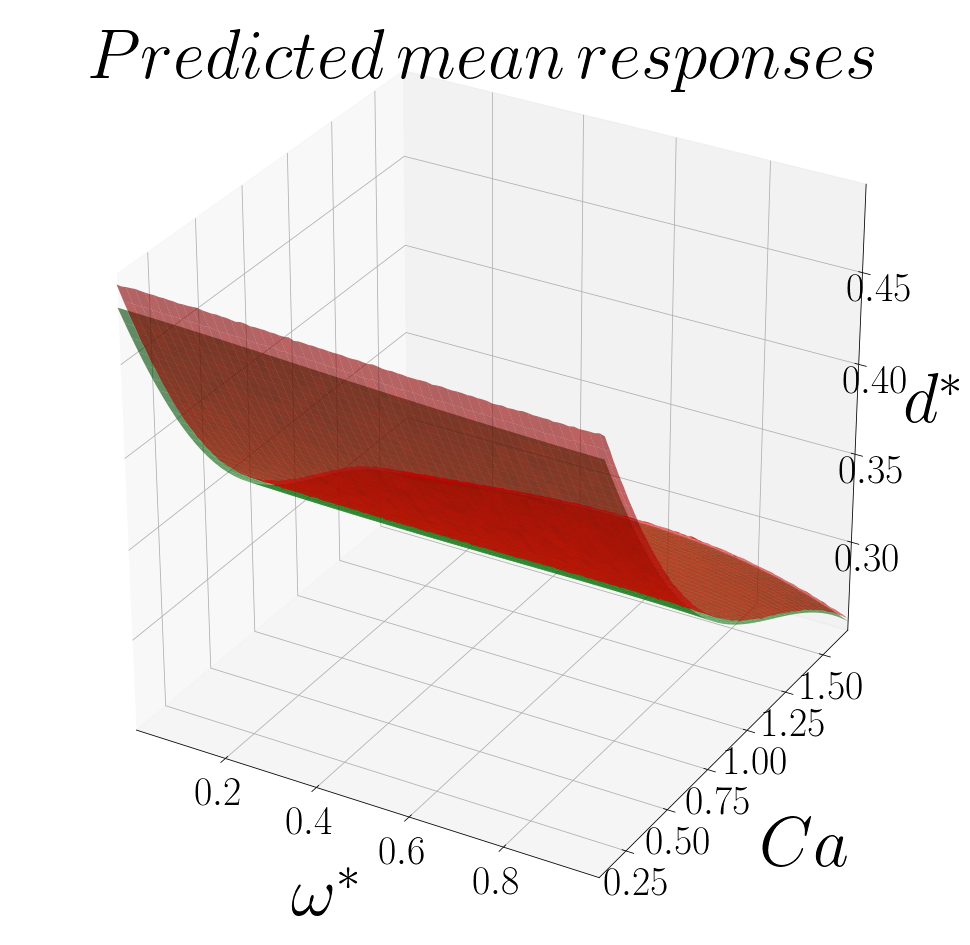

In [25]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')


def get_fix_mins_maxs(mins, maxs):
    deltas = (maxs - mins) / 12.
    mins = mins + deltas / 4.
    maxs = maxs - deltas / 4.
    return [mins, maxs]


os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

if plot == 1:
    Highplot = ml.griddata(Xtest[:,0],Xtest[:,1], mean.flatten(), x1, x2, interp = 'linear')
    Lowplot = ml.griddata(Xtest[:,0],Xtest[:,1], mu1.flatten(), x1, x2, interp = 'linear')
    Varplot = ml.griddata(Xtest[:,0],Xtest[:,1], var.flatten(), x1, x2, interp = 'linear')
    
    fig , ax = plt.subplots(1,1,figsize = (17,17))
    ax = plt.axes(projection='3d')
    ax.plot_surface(x1, x2, Lowplot, color = 'green', rstride=2, cstride=2,
                                    linewidth=0, antialiased=True, shade = True, alpha = 0.6)
    ax.plot_surface(x1, x2, Highplot, color = 'red', rstride=2, cstride=2,
                                    linewidth=0, antialiased=True, shade = True, alpha = 0.6)
    
    plt.title(r'$Predicted \, mean  \, responses$',fontsize=70)
    ax.set_xlabel(r'$\omega^*$', fontsize=70,  rotation=0, labelpad=45)
    ax.set_ylabel(r'$Ca$', fontsize=70, rotation=0, labelpad=62)
    ax.set_zlabel(r'$d^*$', fontsize=70, rotation=0, labelpad=33.5)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)
    ax.tick_params(axis="z", labelsize=40)
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)

    minmax = get_fix_mins_maxs(-0.0, 1.0)
    ## Set each axis limits
    ax.set_xlim(minmax)
    minmax = get_fix_mins_maxs(0.09, 1.67)
    ax.set_ylim(minmax) 
    plt.savefig('surface_plot.png', bbox_inches = 'tight', pad_inches = 0)

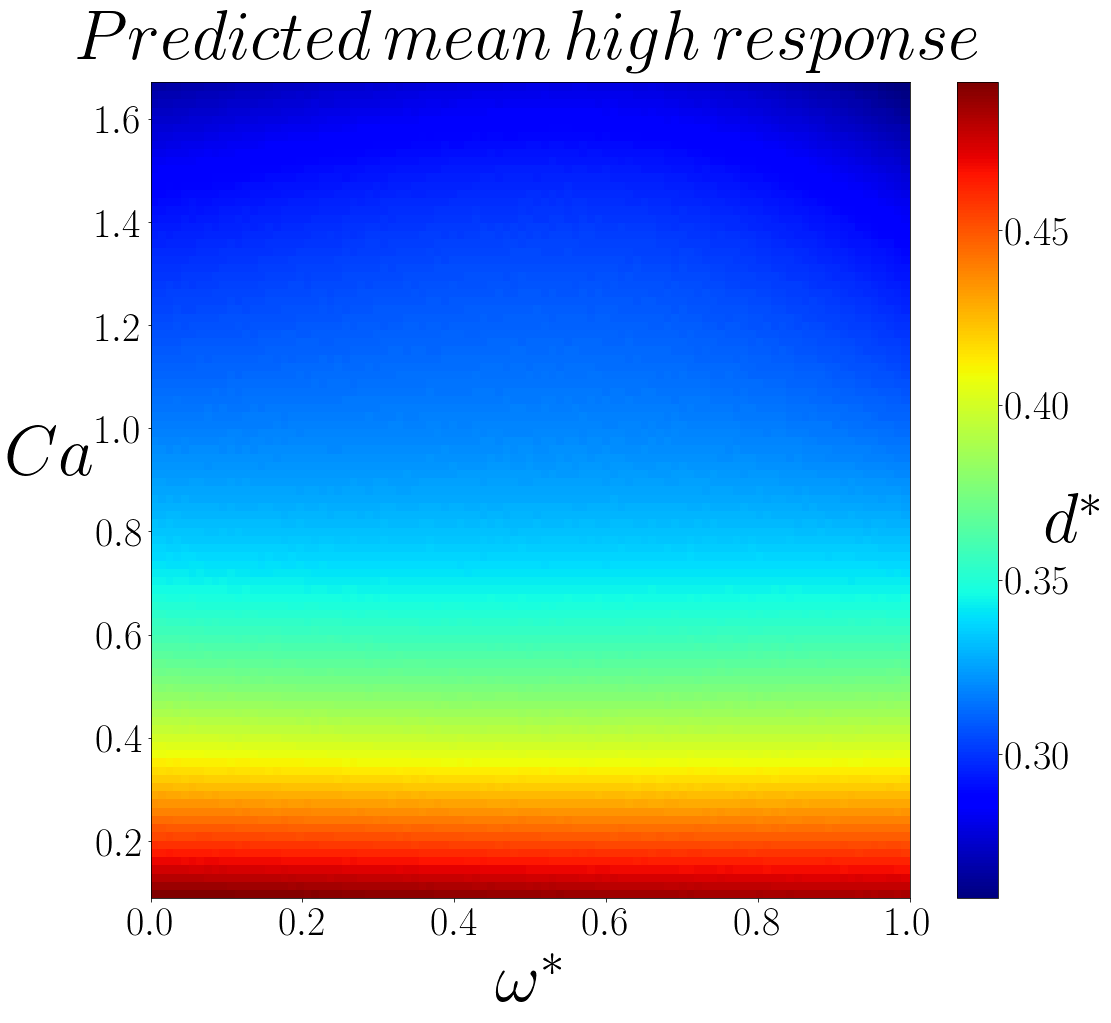

In [26]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

if plot == 1:
    Highplot = ml.griddata(Xtest[:,0],Xtest[:,1], mean.flatten(), x1, x2, interp = 'linear')
    Lowplot = ml.griddata(Xtest[:,0],Xtest[:,1], mu1.flatten(), x1, x2, interp = 'linear')
    Varplot = ml.griddata(Xtest[:,0],Xtest[:,1], var.flatten(), x1, x2, interp = 'linear')
    
    fig , ax = plt.subplots(1,1,figsize = (17,15))
    plt.pcolor(x1, x2, Highplot, cmap='jet')
    cb = plt.colorbar()
    cb.set_label(label=r'$d^*$', size=70, rotation = 0)
    cb.ax.tick_params(labelsize=40)
    plt.title(r'$Predicted \, mean  \, high \, response$',fontsize=70, y = 1.02)
    ax.set_xlabel(r'$\omega^*$', fontsize=70)
    ax.set_ylabel(r'$Ca$', fontsize=70, rotation = 0)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    plt.savefig('mean_high_response.png', bbox_inches = 'tight', pad_inches = 0)

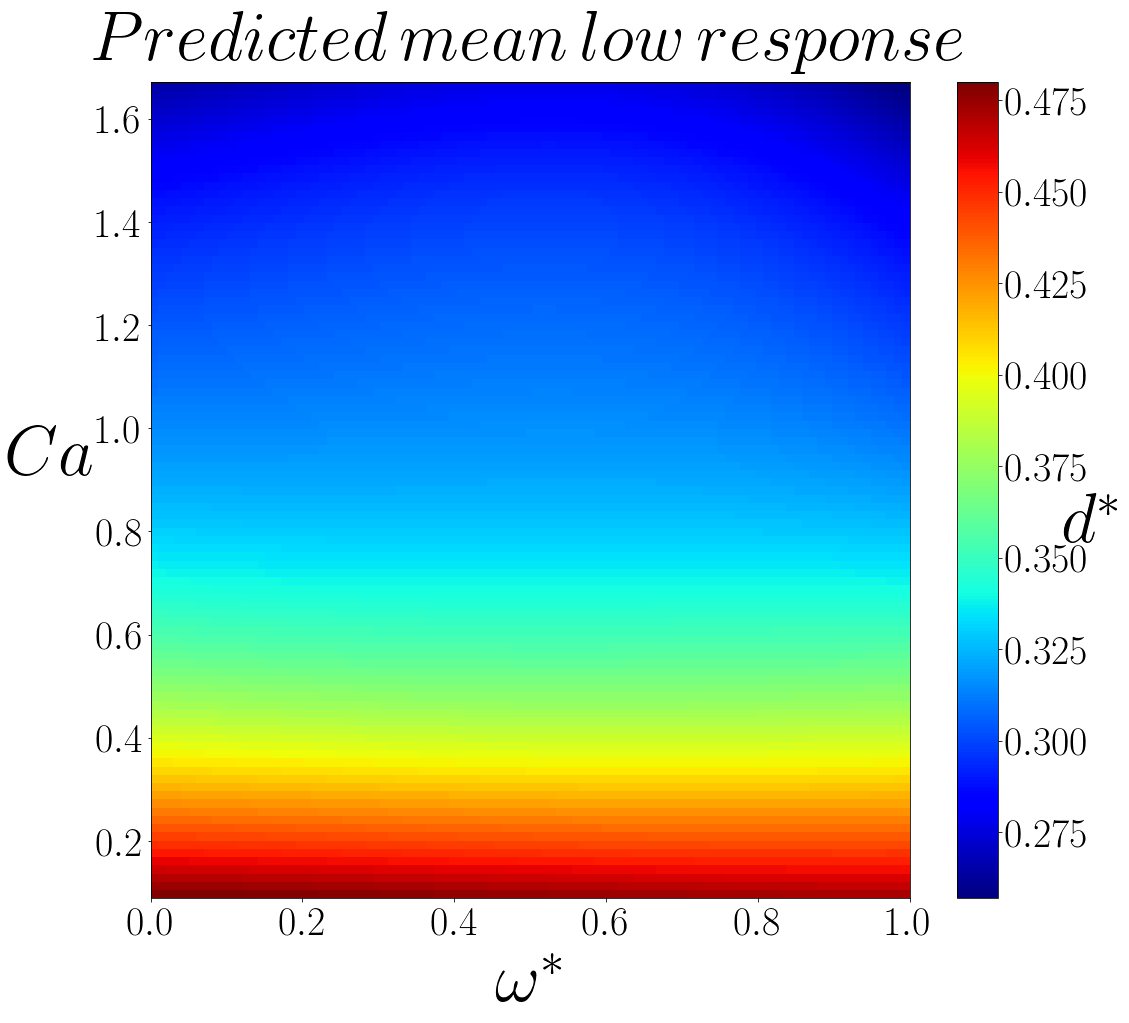

In [27]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

if plot == 1:
    Highplot = ml.griddata(Xtest[:,0],Xtest[:,1], mean.flatten(), x1, x2, interp = 'linear')
    Lowplot = ml.griddata(Xtest[:,0],Xtest[:,1], mu1.flatten(), x1, x2, interp = 'linear')
    Varplot = ml.griddata(Xtest[:,0],Xtest[:,1], var.flatten(), x1, x2, interp = 'linear')
    fig , ax = plt.subplots(1,1,figsize = (17,15))
    
    plt.pcolor(x1, x2, Lowplot, cmap='jet')
    cb = plt.colorbar()
    cb.set_label(label=r'$d^*$', size=70, rotation = 0)
    cb.ax.tick_params(labelsize=40)
    plt.title(r'$Predicted \, mean  \, low \, response$',fontsize=70, y=1.02)
    ax.set_xlabel(r'$\omega^*$', fontsize=70)
    ax.set_ylabel(r'$Ca$', fontsize=70, rotation = 0)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    plt.savefig('mean_low_response.png', bbox_inches = 'tight', pad_inches = 0)

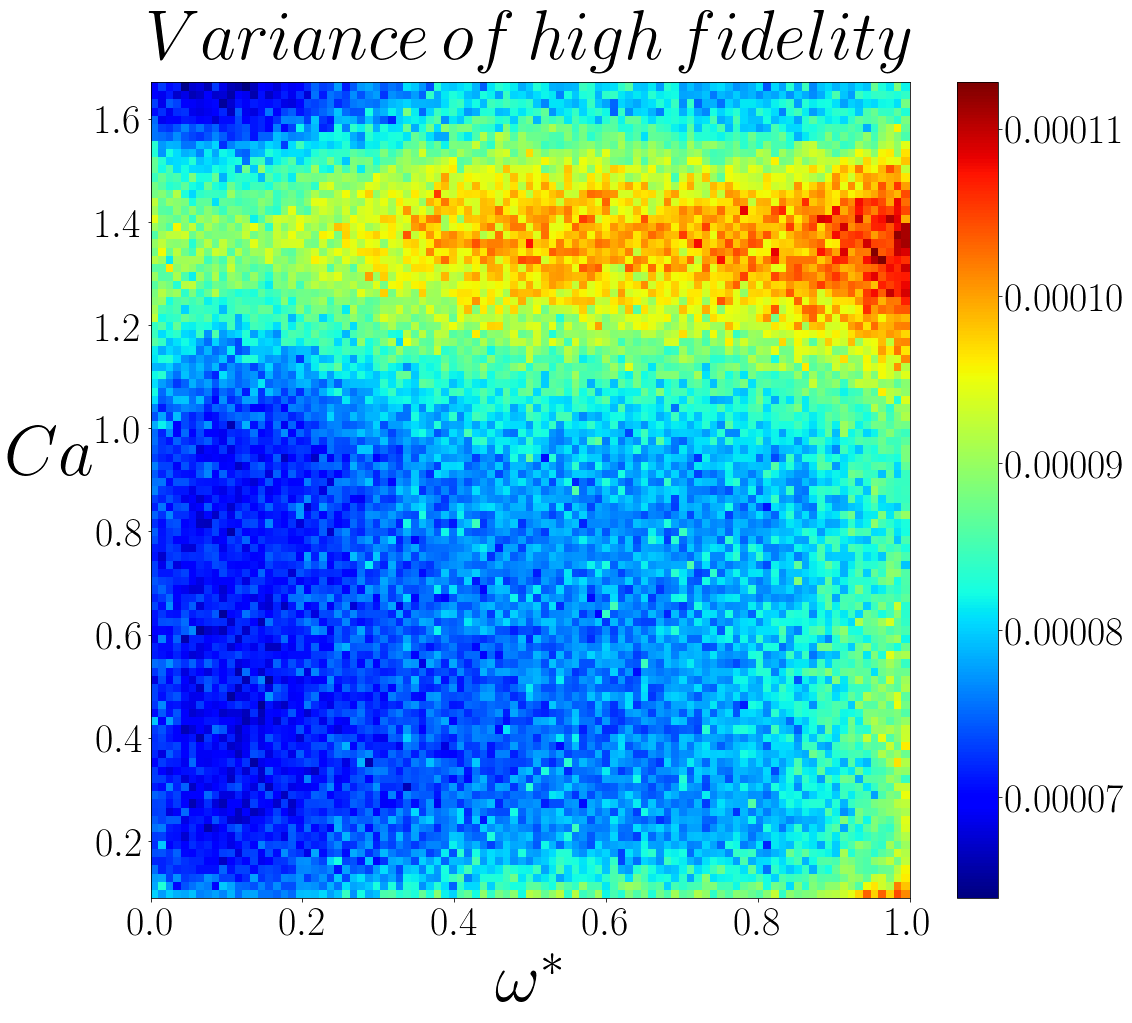

In [28]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

if plot == 1:
    Highplot = ml.griddata(Xtest[:,0],Xtest[:,1], mean.flatten(), x1, x2, interp = 'linear')
    Lowplot = ml.griddata(Xtest[:,0],Xtest[:,1], mu1.flatten(), x1, x2, interp = 'linear')
    Varplot = ml.griddata(Xtest[:,0],Xtest[:,1], var.flatten(), x1, x2, interp = 'linear')

    fig , ax = plt.subplots(1,1,figsize = (17,15))
    plt.pcolor(x1, x2, Varplot, cmap='jet')
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=40)
    plt.title(r'$Variance \, of  \, high \, fidelity$',fontsize=70, y=1.02)
    ax.set_xlabel(r'$\omega^*$', fontsize=70)
    ax.set_ylabel(r'$Ca$', fontsize=70, rotation = 0)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)
    ax.yaxis.set_label_coords(-0.13, 0.5)
    plt.savefig('variance_high_fidelity.png', bbox_inches = 'tight', pad_inches = 0)

In the following cell, we train MFGP on the whole low-fidelity and around 70\% of high-fidelity level data and test it on the rest of the high-fidelity inputs. We repeat this procedure 500 times. Each time, the train and test sets are generated randomly.

In [29]:
number_of_bootstraps = 500
R2_vector = np.zeros(number_of_bootstraps )
MSE_vector = np.zeros(number_of_bootstraps )

weird_predictions = []
R2_weird = []

np.random.seed(11)

for j in range(0, number_of_bootstraps): 
  import random
  ''' Create random training and test sets '''
  training_size = 15
  train_indices = np.random.choice((Xh.shape[0]), training_size, replace=False)
  
  test_indices =  np.setdiff1d(np.arange(Xh.shape[0]), train_indices)
 
  Xh_train = Xh[train_indices, :]
  Yh_train = Yh[train_indices, :]
  Xh_test = Xh[test_indices, :]
  Yh_test = Yh[test_indices, :]
  
  # Prepare data for code
  import GPy
  import numpy as np
  from matplotlib import pyplot as plt
  import matplotlib.mlab as ml
  import matplotlib.patches as mpatches
  import time

  dim = 2
  ntest = Xh_test.shape[0]
  active_dimensions = np.arange(0,dim)
  start = time.time()

  ''' Train level 1 '''
  k1 = GPy.kern.RBF(dim, ARD = True)
  m1 = GPy.models.GPRegression(X=Xl, Y=Yl, kernel=k1)

  m1[".*Gaussian_noise"] = m1.Y.var()*0.01
  m1[".*Gaussian_noise"].fix()

  m1.optimize(max_iters = 500)

  m1[".*Gaussian_noise"].unfix()
  m1[".*Gaussian_noise"].constrain_positive()

  m1.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000, verbose = 0)

  mu1, v1 = m1.predict(Xh_train)


  ''' Train level 2 '''
  XX = np.hstack((Xh_train, mu1))

  k2 = GPy.kern.RBF(1, active_dims = [dim])*GPy.kern.RBF(dim, active_dims = active_dimensions, ARD = True) \
      + GPy.kern.RBF(dim, active_dims = active_dimensions, ARD = True)

  m2 = GPy.models.GPRegression(X=XX, Y=Yh_train, kernel=k2)

  m2[".*Gaussian_noise"] = m2.Y.var()*0.01
  m2[".*Gaussian_noise"].fix()

  m2.optimize(max_iters = 500)

  m2[".*Gaussian_noise"].unfix()
  m2[".*Gaussian_noise"].constrain_positive()

  m2.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000, verbose = 0)

  ''' Predict at test points '''
  # sample f_1 at xtest
  nsamples = 1000
  mu1, C1 = m1.predict(Xh_test, full_cov=True)
  Z = np.random.multivariate_normal(mu1.flatten(),C1,nsamples)

  # push samples through f_2
  tmp_m = np.zeros((nsamples,ntest))
  tmp_v = np.zeros((nsamples,ntest))
  for i in range(0,nsamples):
      mu, v = m2.predict(np.hstack((Xh_test, Z[i,:][:,None])))
      tmp_m[i,:] = mu.flatten()
      tmp_v[i,:] = v.flatten()

  # get posterior mean and variance
  mean = np.mean(tmp_m, axis = 0)[:,None]
  var = np.mean(tmp_v, axis = 0)[:,None]+ np.var(tmp_m, axis = 0)[:,None]
  var = np.abs(var)


  import scipy.stats as st
  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns
  from sklearn.metrics import r2_score
  sns.set_context('talk')
  sns.set_style('white')

  pred_high = mean
  pred_low = mu1
    
  ##Create a vector that contains the MSE of all predictions
  mse = np.mean((Yh_test - pred_high) ** 2)
  MSE_vector[j] = mse

  ##Create a vector that contains the R2 score of all predictions
  R2 = r2_score(Yh_test, pred_high)
  R2_vector[j] = R2
    
  if R2<0:
    weird_predictions.append(pred_high)
    R2_weird.append(R2)
  

In [33]:
  print 'mean of R2 score for all predictions =', np.mean(R2_vector)
  print 'mean of MSE for all predictions =', np.mean(MSE_vector)
  print ""
  print "R2 for all 500 precditions:", R2_vector
  print ""
  print "MSE for all 500 predictions:", MSE_vector

mean of R2 score for all predictions = 0.9857964230637933
mean of MSE for all predictions = 0.00015530666459762703

R2 for all 500 precditions: [ 0.99802991  0.99190938  0.99790657  0.99550062  0.9985142   0.99550092
  0.99750791  0.99903438  0.99705708  0.94418043  0.99051227  0.99837768
  0.94070807  0.97213496  0.99857413  0.99240779  0.99590738  0.99421685
 -0.86047228  0.97350878  0.99849278  0.9977635   0.99947798  0.99576124
  0.99332766  0.9967315   0.98780066  0.99284259  0.99371086  0.99830006
  0.99897568  0.99556206  0.99756544  0.99715901  0.99726151  0.99748796
  0.99801729  0.99629293  0.99602759  0.99668404  0.99698357  0.98375659
  0.99657631  0.96465094  0.99645086  0.99283556  0.99809721  0.91814599
  0.99890968  0.99712619  0.99582516  0.96991202  0.99843826  0.9966024
  0.99289543  0.9969986   0.99565995  0.99892849  0.99306573  0.99872358
  0.99320577  0.99865113  0.99367884  0.99592427  0.99848139  0.99303587
  0.99393804  0.99562835  0.99385824  0.99843764  0.99

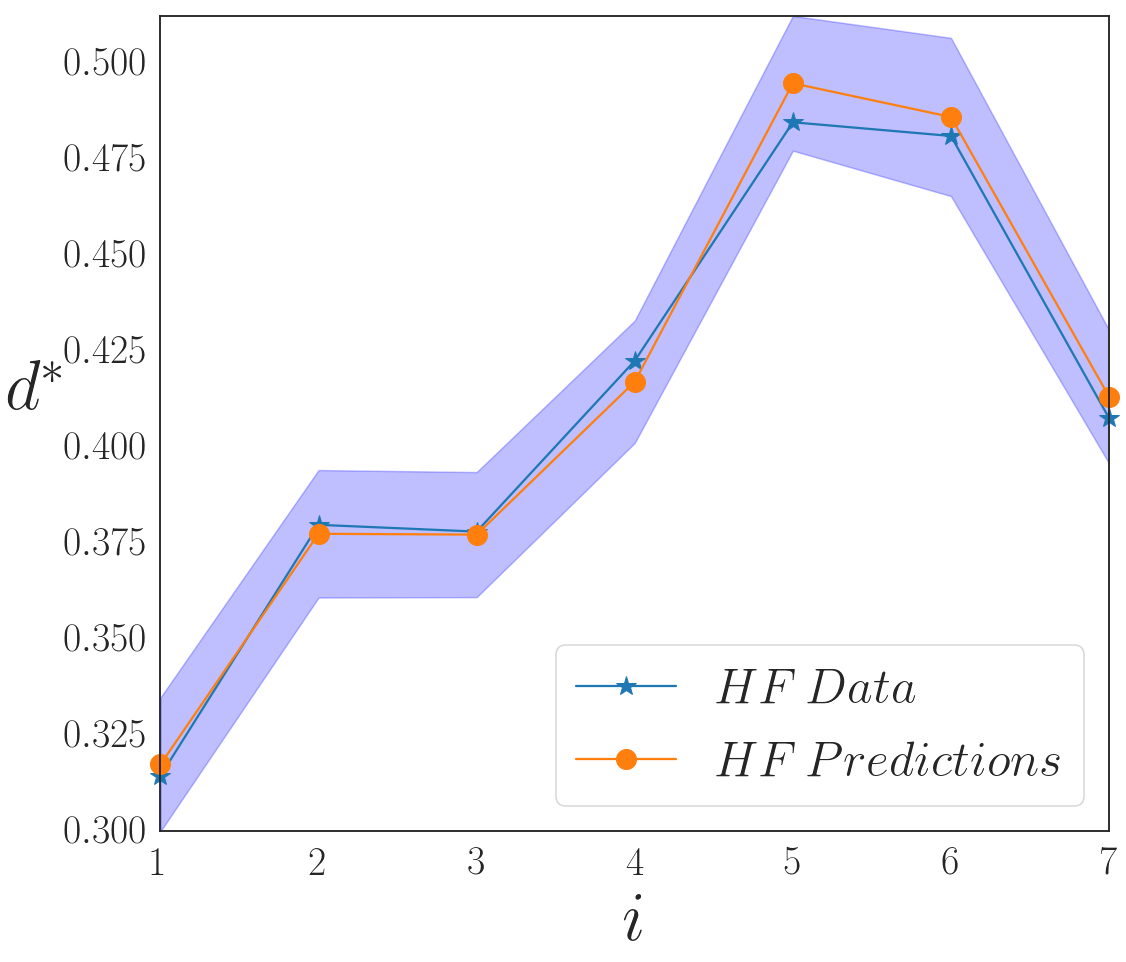

In [34]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

fig , ax = plt.subplots(1,1,figsize = (17,15))
ax.plot(1 + np.arange(Xh_test.shape[0]), Yh_test, marker='*', markersize = 20, clip_on=False)
ax.plot(1 + np.arange(Xh_test.shape[0]), pred_high, marker='o', markersize = 20, clip_on=False)
sp = np.sqrt(var.flatten())
lp = pred_high.flatten() - 2.0 * sp
up = pred_high.flatten() + 2.0 * sp
ax.fill_between(1 + np.arange(Xh_test.shape[0]), lp.flatten(), up.flatten(), color='blue',
                      alpha=0.25)
ax.set_xlabel('$i$', fontsize = 70)
ax.set_ylabel('$d^*$', fontsize=70, rotation=0)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
ax.yaxis.set_label_coords(-0.13, 0.5)
ax.legend([r'$HF \, Data$', r'$HF \, Predictions$'], loc='lower right', fontsize = 50)
plt.xlim(1, Xh_test.shape[0])
plt.ylim(np.min(lp),np.max(up))
plt.savefig('prediction_and_observations.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

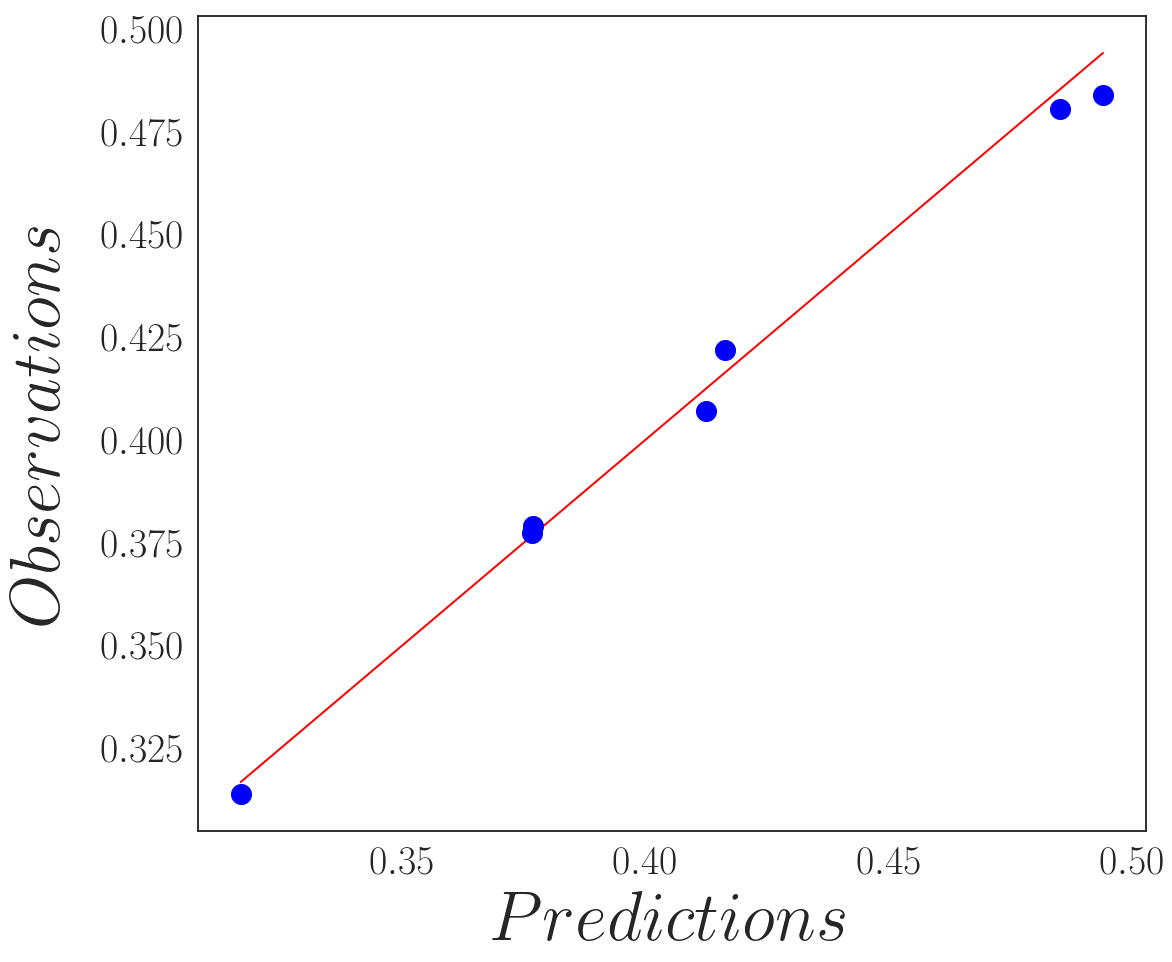

In [35]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

fig , ax = plt.subplots(1,1,figsize = (17,15))
y_range = np.linspace(np.min(pred_high), np.max(pred_high), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(pred_high, Yh_test, 'bo', markersize = 20, clip_on = False)
ax.set_xlabel(r'$Predictions$', fontsize=70)
ax.set_ylabel(r'$Observations$', fontsize=70)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
ax.yaxis.set_label_coords(-0.13, 0.5)
plt.savefig('prediction_vs_observations.png', bbox_inches = 'tight', pad_inches = 0)

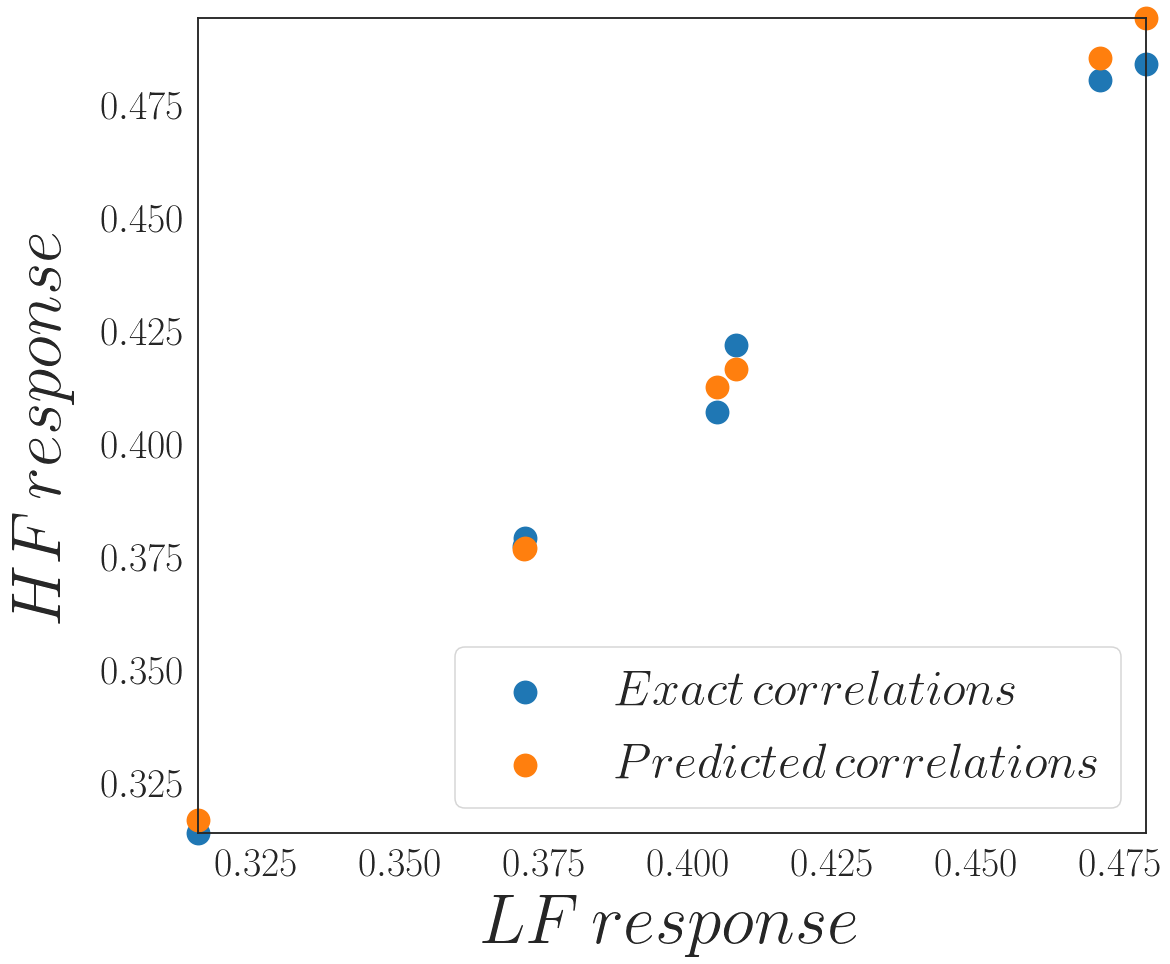

In [36]:
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches

from mpl_toolkits import mplot3d
from matplotlib import rc, rcParams
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
rc('text', usetex=True)
rc('font', weight='bold')

os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/Project')

fig , ax = plt.subplots(1,1,figsize = (17,15))
ax.scatter(mu1, Yh_test, s=500, clip_on = False, label = r'$Exact \, correlations$')
ax.scatter(mu1, mean, s=500, clip_on = False, label = r'$Predicted \, correlations$')
ax.set_xlabel(r'$LF \, response$', fontsize=70)
ax.set_ylabel(r'$HF \, response$', fontsize=70)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
ax.yaxis.set_label_coords(-0.13, 0.5)
plt.xlim(np.min(mu1), np.max(mu1))
plt.ylim( min(np.min(Yh_test), np.min(mean)), max(np.max(Yh_test), np.max(mean)) )
ax.legend(fontsize = 50, loc = 'lower right')
plt.savefig('correlations.png', bbox_inches = 'tight', pad_inches = 0)

As we see here, out of 500 predictions, only 1 resulted in a poor one with a negative R2 score.

In [37]:
print "R2 score for the werid prediction:", R2_weird

R2 score for the werid prediction: [-0.8604722849862323]
